In [1]:
lit_path = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\reworked_data_model\results\lit_results\lit_best_known.csv'
ga_path = r'C:\Users\huda\Downloads\final\final\\'
files = ['s0_s1_3600.txt','s4_3600.txt','s5_s6_s3_3600.txt', 's2a_3600.txt', 's2b_3600.txt', 's2c_s2d_3600.txt', 'behnke_geiger_repeat.txt', 'chambers.txt', 'dppaulli.txt', 'fattahi.txt', 'behnkegeiger.txt', 'brandimarte.txt']
files2 = ['chambers.txt', 'dppaulli.txt', 'fattahi.txt', 'behnkegeiger.txt', 'brandimarte.txt']
gurobi_30 = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\reworked_data_model\results\gurobi_results\formatted_results\30_min.txt'
gurobi_60 = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\reworked_data_model\results\gurobi_results\formatted_results\60_min.txt'

In [2]:
from translation import FJSSPInstancesTranslator, SequenceGAEncoder
from model import ProductionEnvironment, Order

benchmark_base_path = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\external_test_data\FJSSPinstances\\'

def generate_one_order_per_recipe(production_environment : ProductionEnvironment) -> list[Order]:
    orders : list[Order] = []
    for i in range(len(production_environment.resources.values())): # should be the same amount as recipes for now
        orders.append(Order(delivery_time=1000, latest_acceptable_time=1000, resources=[(production_environment.get_resource(i), 1)], penalty=100.0, tardiness_fee=50.0, divisible=False, profit=500.0))
    return orders

def read_benchmark_file(source, instance):
    if source.startswith('0'):
        target_file = f'Behnke{instance}.fjs'
    elif source.startswith('1'):
        target_file = f'BrandimarteMk{instance}.fjs'
    elif source.startswith('2a'):
        target_file = f'HurinkSdata{instance}.fjs'
    elif source.startswith('2b'):
        target_file = f'HurinkEdata{instance}.fjs'
    elif source.startswith('2c'):
        target_file = f'HurinkRdata{instance}.fjs'
    elif source.startswith('2d'):
        target_file = f'HurinkVdata{instance}.fjs'
    elif source.startswith('3'):
        target_file = f'DPpaulli{instance}.fjs'
    elif source.startswith('4'):
        target_file = f'ChambersBarnes{instance}.fjs'
    elif source.startswith('5'):
        target_file = f'Kacem{instance}.fjs'
    elif source.startswith('6'):
        target_file = f'Fattahi{instance}.fjs'
    path = benchmark_base_path + f'{source}\\{target_file}'
    return open(path, 'r').readlines()

def load_benchmark_data(content):   
    line = dict()
    line['source'] = content[0]
    line['instance'] = int(content[1])

    # add information about the benchmark instance
    benchmark_file = read_benchmark_file(line['source'], line['instance'])
    benchmark_system = benchmark_file[0].split(' ')
    line['n_machines'] = int(benchmark_system[1])
    line['n_jobs'] = int(benchmark_system[0])
    line['average_workstations_per_operation'] = float(benchmark_system[2])
    jobs = benchmark_file[1:]
    line['n_operations'] = sum([int(x.split(' ')[0]) for x in jobs])
    line['average_operations_per_job'] = line['n_operations'] / line['n_jobs']
    line['beta_flexibility'] = line['average_workstations_per_operation']/line['n_machines']
    line['approximate_max_dissimilarity'] = line['n_operations'] + line['average_operations_per_job'] * line['average_workstations_per_operation']

    production_environment = FJSSPInstancesTranslator().translate(line['source'], line['instance'])
    orders = generate_one_order_per_recipe(production_environment)
    production_environment.orders = orders
    workstations_per_operation, base_durations, job_operations = SequenceGAEncoder().encode(production_environment, orders)
    unique_durations = []
    overall_amount_durations = []
    for duration in base_durations:
        for d in duration:
            if d not in unique_durations and d > 0:
                unique_durations.append(d)
        overall_amount_durations.extend([x for x in duration if x > 0])
    overall_amount_durations = len(overall_amount_durations)
    line['duration_variety'] = (len(unique_durations)/overall_amount_durations)
    return line    

In [3]:
data = dict()
benchmark_data = []
for file in files:
    content = open(ga_path + file, 'r').readlines()
    for values in content:
        line = values.split(';')

        uid = line[0]+line[1]
        if True or not uid.startswith('2a'):
            if uid not in data:
                data[uid] = [float(line[6])]
            elif data[uid][0] > float(line[6]):
                data[uid] = [float(line[6])]
"""for file in files2:
    content = open(ga_path + file, 'r').readlines()
    for values in content:
        line = values.split(';')
        uid = line[0]+line[1]
        if uid not in data:
            data[uid] = [float(line)]"""

"for file in files2:\n    content = open(ga_path + file, 'r').readlines()\n    for values in content:\n        line = values.split(';')\n        uid = line[0]+line[1]\n        if uid not in data:\n            data[uid] = [float(line)]"

In [4]:
content = open(lit_path, 'r').readlines()
for values in content[1:]:
    line = values.split(';')
    uid = line[0]+line[1]
    #if not any([x['source'] == line[0] and x['instance'] == line[1] for x in benchmark_data]):
    benchmark_data.append(load_benchmark_data(line))
    if True or not uid.startswith('2a'):
        if uid in data: # skip remaining benchmarks
            value = float(line[3])
            if value < 0:
                value = 10000000 # replacing missing data
            data[uid].append(value)

In [5]:
content = open(gurobi_30, 'r').readlines()
for values in content[1:]:
    line = values.split(';')
    uid = line[0]+line[1]
    if True or not uid.startswith('2a'):
        if uid in data: # skip remaining benchmarks
            data[uid].append(int(float(line[2]) + 0.5))

In [6]:
content = open(gurobi_60, 'r').readlines()
for values in content[1:]:
    line = values.split(';')
    uid = line[0]+line[1]
    if True or not uid.startswith('2a'):
        if uid in data: # skip remaining benchmarks
            data[uid][2] = (int(float(line[2]) + 0.5)) # assuming 60 min is better than the 30 min result

In [7]:
def calc_gap(best, value):
    return (value - best)/best

In [8]:
# NOTE: 0 - GA, 1 - Lit, 2 - Gurobi
best = dict()
for key in data.keys():
    best[key] = min(data[key])
gaps = dict()
for key in best.keys():
    gaps[key] = dict()
    gaps[key]['GA'] = (calc_gap(best[key], data[key][0])) # GA
    gaps[key]['Literature'] = (calc_gap(best[key], data[key][1])) # Lit
    gaps[key]['Gurobi'] = (calc_gap(best[key], data[key][2])) # Gurobi
import pandas as pd
df = pd.DataFrame(gaps)

In [9]:
df

,1_Brandimarte1,1_Brandimarte2,1_Brandimarte3,1_Brandimarte4,1_Brandimarte5,1_Brandimarte6,1_Brandimarte7,1_Brandimarte8,1_Brandimarte9,1_Brandimarte10,...,2d_Hurink_vdata57,2d_Hurink_vdata58,2d_Hurink_vdata59,2d_Hurink_vdata60,2d_Hurink_vdata61,2d_Hurink_vdata62,2d_Hurink_vdata63,2d_Hurink_vdata64,2d_Hurink_vdata65,2d_Hurink_vdata66
GA,0.0,0.000000,0.0,0.0,0.005814,0.086207,0.014388,0.0,0.042345,0.253807,...,0.0,0.01129,0.0,0.0,0.003425,0.0,0.021818,0.0,0.0,0.0
Literature,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
Gurobi,0.0,0.038462,0.0,0.0,0.005814,0.103448,0.035971,0.0,0.009772,0.101523,...,0.0,0.00000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [10]:
instances = gaps.keys()
ga_values = [gaps[x]['GA'] for x in instances]
lit_values = [gaps[x]['Literature'] for x in instances]
gurobi_values = [gaps[x]['Gurobi'] for x in instances]

In [11]:
bins = [0.0, 0.01, 0.02, 0.03, 0.05, 0.15, 0.35]
counts = []
eps = 0.000001
for i in range(len(bins)):
    counts.append(0)
    if i == 0:
        for value in ga_values:
            if value <= bins[i] + eps:
                counts[i] += 1
    else:
        for value in ga_values:
            if value > bins[i-1] and value <= bins[i]:
                counts[i] += 1
print(counts)
print(sum(counts))
print(len(ga_values))

[109, 52, 39, 37, 49, 86, 23]
395
402


<BarContainer object of 7 artists>

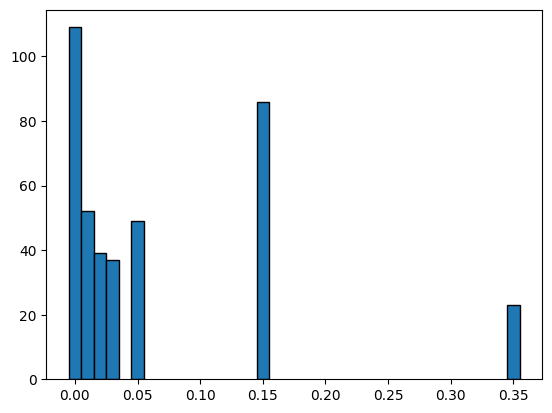

In [12]:
import matplotlib.pyplot as plt
#import numpy as np
#bins = [0.0, 0.01, 0.02, 0.03, 0.05, 0.15, 0.35]
#counts, bins = np.histogram(ga_values, bins=bins)
#plt.hist(bins[:-1], bins, weights=counts, edgecolor='black')
plt.bar(bins, counts, edgecolor='black', align='center', width=0.01)
#plt.xticks(bins-.5, bins)
#plt.hlines(0.05, 0, len(values), colors='r')

<AxesSubplot: >

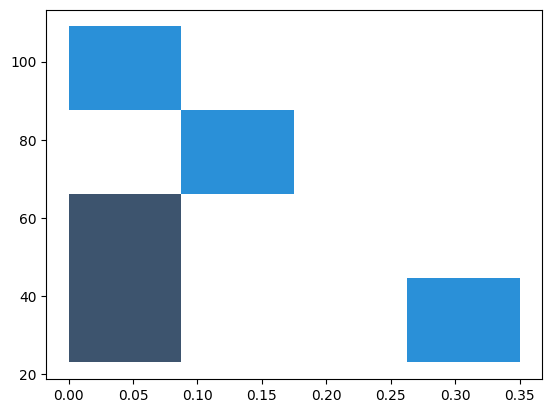

In [13]:
import seaborn as sns
sns.histplot(x=bins, y=counts)

0.5119887165021156
0.5359848484848485


Text(0.5, 1.0, 'Result Overview')

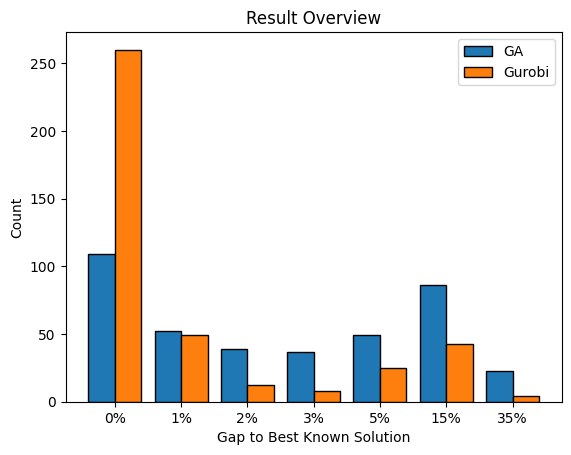

In [14]:
bins = [0.0, 0.01, 0.02, 0.03, 0.05, 0.15, 0.35]
counts = []
eps = 0.000001
for i in range(len(bins)):
    counts.append(0)
    if i == 0:
        for value in ga_values:
            if value <= bins[i] + eps:
                counts[i] += 1
    else:
        for value in ga_values:
            if value > bins[i-1] and value <= bins[i]:
                counts[i] += 1
counts_gurobi = []               
for i in range(len(bins)):
    counts_gurobi.append(0)
    if i == 0:
        for value in gurobi_values:
            if value <= bins[i] + eps:
                counts_gurobi[i] += 1
    else:
        for value in gurobi_values:
            if value > bins[i-1] and value <= bins[i]:
                counts_gurobi[i] += 1

print(max(gurobi_values))
print(max(ga_values))
import numpy as np
x_axis = np.arange(len(bins))
fig, ax = plt.subplots()
#ax.step(x_axis, counts)
ax.bar(x_axis -0.2, counts, width=0.4, edgecolor='black', label='GA')
ax.bar(x_axis +0.2, counts_gurobi, width=0.4, edgecolor='black', label='Gurobi')
ax.set_xticks([i for i, j in enumerate(counts)])
ax.set_xticklabels(['0%', '1%', '2%', '3%', '5%', '15%', '35%'])
plt.legend()
plt.xlabel('Gap to Best Known Solution')
plt.ylabel('Count')
plt.title('Result Overview')

In [15]:
ga_inside_percentage = []
ga_values_sorted = sorted(ga_values)

for value in ga_values_sorted:
    count = 0
    i = 0
    while i < len(ga_values_sorted) and ga_values_sorted[i] <= value:
        count += 1
        i+=1
    ga_inside_percentage.append(count/len(ga_values_sorted))
print(len(ga_inside_percentage))
gurobi_inside_percentage = []
gurobi_values_sorted = sorted(gurobi_values)

for value in gurobi_values_sorted:
    count = 0
    i = 0
    while i < len(gurobi_values_sorted) and gurobi_values_sorted[i] <= value:
        count += 1
        i+=1
    gurobi_inside_percentage.append(count/len(gurobi_values_sorted))
print(len(gurobi_inside_percentage))
lit_inside_percentage = []
lit_values_sorted = sorted(lit_values)

for value in gurobi_values_sorted:
    count = 0
    i = 0
    while i < len(lit_values_sorted) and lit_values_sorted[i] <= value:
        count += 1
        i+=1
    lit_inside_percentage.append(count/len(lit_values_sorted))
print(len(lit_inside_percentage))

402
402
402


In [16]:
print(ga_inside_percentage)

[0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.27114427860696516, 0.2711442786

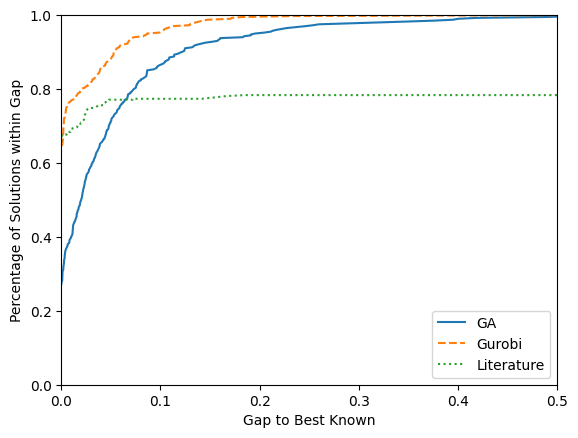

In [17]:
fig2, ax2 = plt.subplots()
x_axis = np.arange(0.0, 0.5, 0.1)
ax2.plot(ga_values_sorted, ga_inside_percentage, linestyle='solid', label='GA')
ax2.plot(gurobi_values_sorted, gurobi_inside_percentage, linestyle='dashed', label='Gurobi')
ax2.plot(lit_values_sorted, lit_inside_percentage, linestyle='dotted', label='Literature')
ax2.set_xlabel('Gap to Best Known')
ax2.set_ylabel('Percentage of Solutions within Gap')
"""ax2.scatter(instances, ga_values, s=1, marker='o', label='GA')
ax2.scatter(instances, gurobi_values, s=1, marker='v', label='Gurobi')
ax2.scatter(instances, lit_values, s=1, marker='s', label='Literature')"""
#fig2.set_figwidth(15)
ax2.set_xlim(0.0, 0.5)
ax2.set_ylim(0.0, 1.0)

plt.legend(loc='lower right')


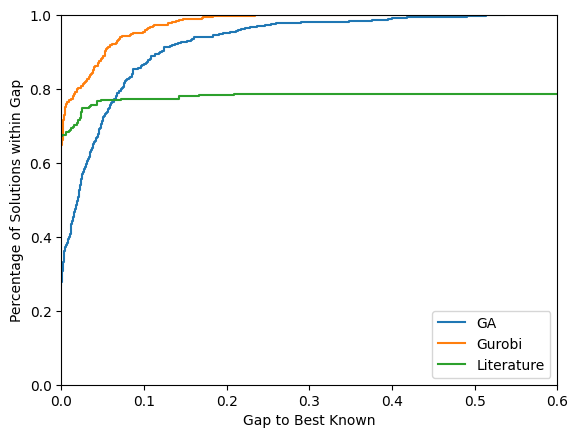

In [18]:
fig2, ax2 = plt.subplots()
x_axis = np.arange(0.0, 0.5, 0.1)
ga_x = ga_values_sorted.copy()


ax2.step(ga_x, ga_inside_percentage, label='GA')
ax2.step(gurobi_values_sorted, gurobi_inside_percentage, label='Gurobi')
ax2.step(lit_values_sorted, lit_inside_percentage, label='Literature')
ax2.set_xlabel('Gap to Best Known')
ax2.set_ylabel('Percentage of Solutions within Gap')
"""ax2.scatter(instances, ga_values, s=1, marker='o', label='GA')
ax2.scatter(instances, gurobi_values, s=1, marker='v', label='Gurobi')
ax2.scatter(instances, lit_values, s=1, marker='s', label='Literature')"""
#fig2.set_figwidth(15)
ax2.set_xlim(0.0, 0.6)
ax2.set_ylim(0.0, 1.0)
#ax2.vlines([0.05, 0.1, 0.2], 0.0, 1.0, 'r', 'dashed')
plt.legend(loc='lower right')


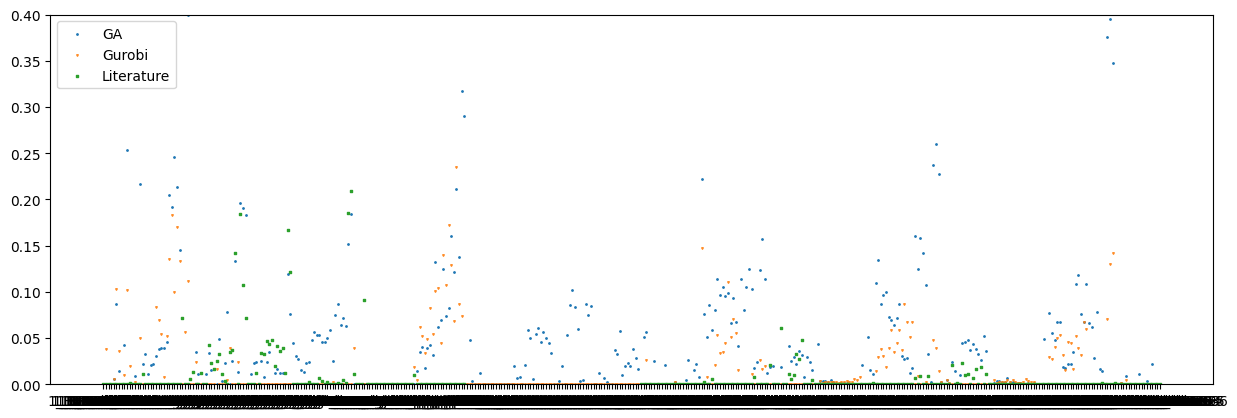

In [19]:
fig2, ax2 = plt.subplots()
ax2.scatter(instances, ga_values, s=1, marker='o', label='GA')
ax2.scatter(instances, gurobi_values, s=1, marker='v', label='Gurobi')
ax2.scatter(instances, lit_values, s=1, marker='s', label='Literature')
fig2.set_figwidth(15)
ax2.set_ylim(0.0, 0.4)
plt.legend()


<AxesSubplot: xlabel='Count', ylabel='Count'>

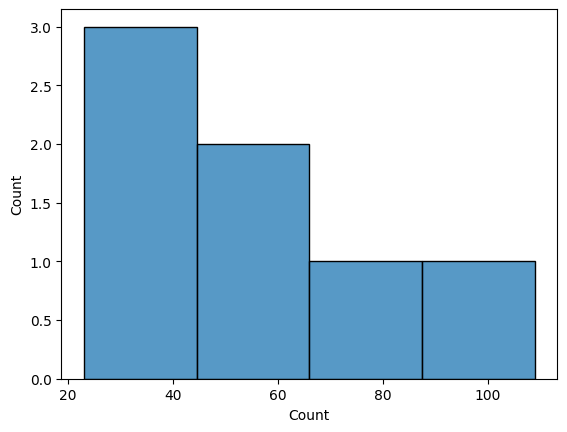

In [20]:
c = dict()
c['Count'] = counts
c = [{
    'Bin': '0%',
    'Count': counts[0]
},
{
    'Bin': '1%',
    'Count': counts[1]
},
{
    'Bin': '2%',
    'Count': counts[2]
},
{
    'Bin': '3%',
    'Count': counts[3]
},
{
    'Bin': '5%',
    'Count': counts[4]
},
{
    'Bin': '15%',
    'Count': counts[5]
},
{
    'Bin': '35%',
    'Count': counts[6]
},
]
c_df = pd.DataFrame(c)
sns.histplot(data=c_df, x='Count')

In [21]:
c_df

,Bin,Count
0,0%,109
1,1%,52
2,2%,39
3,3%,37
4,5%,49
5,15%,86
6,35%,23


In [22]:
ga_values_dict = dict()
ga_values_dict['Gap'] = ga_values
ga_hist_df = pd.DataFrame(ga_values_dict)
gurobi_values_dict = dict()
gurobi_values_dict['Gap'] = gurobi_values
guorbi_hist_df = pd.DataFrame(gurobi_values)


<AxesSubplot: xlabel='Gap', ylabel='Count'>

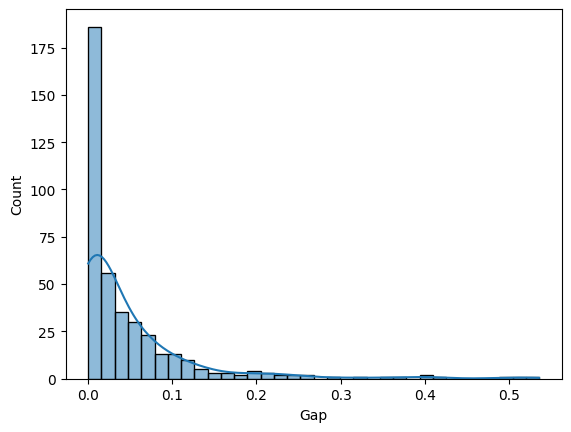

In [23]:
sns.histplot(data=ga_hist_df, x='Gap', kde=True)


<AxesSubplot: xlabel='Gap'>

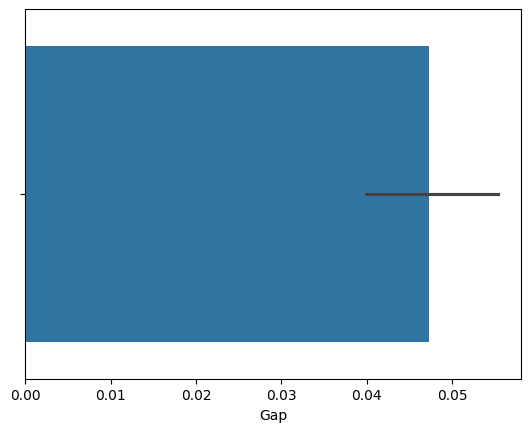

In [24]:
sns.barplot(data=ga_hist_df, x='Gap')

<AxesSubplot: xlabel='Gap', ylabel='Count'>

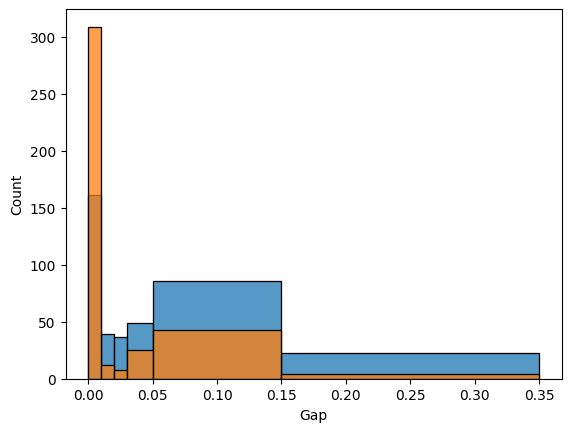

In [25]:
sns.histplot(data=ga_hist_df, x='Gap', bins=bins, multiple='dodge')
sns.histplot(data=gurobi_values_dict, x='Gap', bins=bins, multiple='dodge')

In [26]:
differences = dict()
for key in data.keys():
    differences[key] = [data[key][0] - data[key][1], data[key][0] - data[key][2], data[key][1] - data[key][2]]

In [27]:
ga_wins = []
gurobi_wins = []
lit_wins = []
overall_ties = []
ties = []
ga = []
lit = []
for key in differences.keys(): # 0 -> GA - Lit
    #if not key.startswith('2a'):
        if differences[key][0] == 0:
            ties.append(key)
            if key not in overall_ties:
                overall_ties.append(key)
        elif differences[key][0] >0:
            lit.append(key)
            if not key in lit_wins:
                lit_wins.append(key)
        else:
            ga.append(key)
            ga_wins.append(key)

In [28]:
print(f'Ties:{len(ties)}')
print(f'Lit:{len(lit)}')
print(f'GA:{len(ga)}')

Ties:80
Lit:226
GA:96


In [29]:
for key in ga:
    print(f'Key: {key}: {differences[key][0]}')

Key: 1_Brandimarte11: -1.0
Key: 0_BehnkeGeiger26: -1.0
Key: 0_BehnkeGeiger27: -1.0
Key: 0_BehnkeGeiger29: -3.0
Key: 0_BehnkeGeiger31: -2.0
Key: 0_BehnkeGeiger34: -9.0
Key: 0_BehnkeGeiger35: -3.0
Key: 0_BehnkeGeiger36: -4.0
Key: 0_BehnkeGeiger46: -1.0
Key: 0_BehnkeGeiger47: -3.0
Key: 0_BehnkeGeiger48: -3.0
Key: 0_BehnkeGeiger49: -1.0
Key: 0_BehnkeGeiger51: -2.0
Key: 0_BehnkeGeiger52: -6.0
Key: 0_BehnkeGeiger53: -6.0
Key: 0_BehnkeGeiger54: -7.0
Key: 0_BehnkeGeiger55: -3.0
Key: 0_BehnkeGeiger56: -22.0
Key: 0_BehnkeGeiger57: -22.0
Key: 0_BehnkeGeiger58: -15.0
Key: 0_BehnkeGeiger59: -11.0
Key: 0_BehnkeGeiger60: -6.0
Key: 5_Kacem4: -1.0
Key: 6_Fattahi19: -10.0
Key: 2a_Hurink_sdata1: -9999945.0
Key: 2a_Hurink_sdata2: -9999026.0
Key: 2a_Hurink_sdata3: -9998819.0
Key: 2a_Hurink_sdata4: -9999334.0
Key: 2a_Hurink_sdata5: -9999345.0
Key: 2a_Hurink_sdata6: -9999396.0
Key: 2a_Hurink_sdata7: -9999410.0
Key: 2a_Hurink_sdata8: -9999407.0
Key: 2a_Hurink_sdata9: -9999074.0
Key: 2a_Hurink_sdata10: -999911

In [30]:
ties = []
ga = []
lit = []
for key in differences.keys(): # 1 -> Lit - Gurobi
    if not key.startswith('2a'):
        if differences[key][2] == 0:
            ties.append(key)
            if key not in overall_ties:
                overall_ties.append(key)
        elif differences[key][2] < 0:
            lit.append(key)
            if not key in lit_wins:
                lit_wins.append(key)
        else:
            ga.append(key)
            gurobi_wins.append(key)


In [31]:
print(f'Ties:{len(ties)}')
print(f'Lit:{len(lit)}')
print(f'Gurobi:{len(ga)}')

Ties:128
Lit:141
Gurobi:67


In [32]:
for key in ga:
    print(f'Key: {key}: {differences[key][1]}')

Key: 0_BehnkeGeiger1: 2.0
Key: 0_BehnkeGeiger16: 283.0
Key: 0_BehnkeGeiger19: 272.0
Key: 0_BehnkeGeiger20: 253.0
Key: 0_BehnkeGeiger23: 1.0
Key: 0_BehnkeGeiger26: 4.0
Key: 0_BehnkeGeiger27: 2.0
Key: 0_BehnkeGeiger28: 2.0
Key: 0_BehnkeGeiger29: -2.0
Key: 0_BehnkeGeiger30: 6.0
Key: 0_BehnkeGeiger31: 1.0
Key: 0_BehnkeGeiger32: 6.0
Key: 0_BehnkeGeiger35: 6.0
Key: 0_BehnkeGeiger36: 62.0
Key: 0_BehnkeGeiger38: 87.0
Key: 0_BehnkeGeiger39: 89.0
Key: 0_BehnkeGeiger40: 89.0
Key: 0_BehnkeGeiger44: 2.0
Key: 0_BehnkeGeiger46: 3.0
Key: 0_BehnkeGeiger47: 1.0
Key: 0_BehnkeGeiger48: 3.0
Key: 0_BehnkeGeiger49: 4.0
Key: 0_BehnkeGeiger50: 6.0
Key: 0_BehnkeGeiger51: 3.0
Key: 0_BehnkeGeiger52: 4.0
Key: 0_BehnkeGeiger53: 3.0
Key: 0_BehnkeGeiger54: 3.0
Key: 0_BehnkeGeiger55: 0.0
Key: 0_BehnkeGeiger56: 55.0
Key: 0_BehnkeGeiger57: 36.0
Key: 4_ChambersBarnes7: 22.0
Key: 4_ChambersBarnes11: 48.0
Key: 4_ChambersBarnes12: 41.0
Key: 4_ChambersBarnes14: 45.0
Key: 4_ChambersBarnes18: 98.0
Key: 4_ChambersBarnes20: 84.0

In [33]:
ties = []
ga = []
lit = []
for key in differences.keys(): # 1 -> GA - Gurobi
    if differences[key][1] == 0:
        ties.append(key)
    elif differences[key][1] > 0:
        lit.append(key)
    else:
        ga.append(key)

In [34]:
print(f'Ties:{len(ties)}')
print(f'Gurobi:{len(lit)}')
print(f'GA:{len(ga)}')

Ties:103
Gurobi:243
GA:56


In [35]:
gurobi = lit
print('Gurobi')
print(gurobi)
print('GA')
print(ga)
print('TIE')
print(ties)

Gurobi
['1_Brandimarte9', '1_Brandimarte10', '1_Brandimarte13', '1_Brandimarte15', '0_BehnkeGeiger1', '0_BehnkeGeiger2', '0_BehnkeGeiger3', '0_BehnkeGeiger4', '0_BehnkeGeiger5', '0_BehnkeGeiger9', '0_BehnkeGeiger11', '0_BehnkeGeiger12', '0_BehnkeGeiger13', '0_BehnkeGeiger14', '0_BehnkeGeiger15', '0_BehnkeGeiger16', '0_BehnkeGeiger17', '0_BehnkeGeiger18', '0_BehnkeGeiger19', '0_BehnkeGeiger20', '0_BehnkeGeiger21', '0_BehnkeGeiger22', '0_BehnkeGeiger23', '0_BehnkeGeiger25', '0_BehnkeGeiger26', '0_BehnkeGeiger27', '0_BehnkeGeiger28', '0_BehnkeGeiger30', '0_BehnkeGeiger31', '0_BehnkeGeiger32', '0_BehnkeGeiger33', '0_BehnkeGeiger35', '0_BehnkeGeiger36', '0_BehnkeGeiger38', '0_BehnkeGeiger39', '0_BehnkeGeiger40', '0_BehnkeGeiger42', '0_BehnkeGeiger43', '0_BehnkeGeiger44', '0_BehnkeGeiger46', '0_BehnkeGeiger47', '0_BehnkeGeiger48', '0_BehnkeGeiger49', '0_BehnkeGeiger50', '0_BehnkeGeiger51', '0_BehnkeGeiger52', '0_BehnkeGeiger53', '0_BehnkeGeiger54', '0_BehnkeGeiger56', '0_BehnkeGeiger57', '4_

In [36]:
cleaned_gurobi = []
cleaned_ga = []
cleaned_ties = []
for entry in gurobi:
    i = len(entry)-1
    while i > 0 and entry[i].isnumeric():
        i-=1
    cleaned_gurobi.append((entry[:i+1], int(entry[i+1:])))
for entry in ga:
    i = len(entry)-1
    while i > 0 and entry[i].isnumeric():
        i-=1
    cleaned_ga.append((entry[:i+1], int(entry[i+1:])))
for entry in ties:
    i = len(entry)-1
    while i > 0 and entry[i].isnumeric():
        i-=1
    cleaned_ties.append((entry[:i+1], int(entry[i+1:])))



In [37]:
for key in ga:
    print(f'Key: {key}: {differences[key][2]}')

Key: 1_Brandimarte2: -1.0
Key: 1_Brandimarte6: -6.0
Key: 1_Brandimarte7: -5.0
Key: 1_Brandimarte11: -11.0
Key: 0_BehnkeGeiger6: -11.0
Key: 0_BehnkeGeiger7: -9.0
Key: 0_BehnkeGeiger8: -7.0
Key: 0_BehnkeGeiger10: -7.0
Key: 0_BehnkeGeiger29: 1.0
Key: 0_BehnkeGeiger34: -1.0
Key: 0_BehnkeGeiger37: -13.0
Key: 0_BehnkeGeiger60: -15.0
Key: 6_Fattahi19: -10.0
Key: 3_DPpaulli1: -155.0
Key: 3_DPpaulli2: -117.0
Key: 3_DPpaulli3: -74.0
Key: 3_DPpaulli4: -121.0
Key: 3_DPpaulli5: -183.0
Key: 3_DPpaulli6: -120.0
Key: 3_DPpaulli8: -216.0
Key: 3_DPpaulli10: -319.0
Key: 3_DPpaulli11: -221.0
Key: 3_DPpaulli12: -349.0
Key: 3_DPpaulli15: -508.0
Key: 3_DPpaulli18: -1089.0
Key: 2b_Hurink_edata34: -170.0
Key: 2c_Hurink_rdata3: -4.0
Key: 2c_Hurink_rdata9: -2.0
Key: 2c_Hurink_rdata10: -1.0
Key: 2c_Hurink_rdata11: -2.0
Key: 2c_Hurink_rdata12: -2.0
Key: 2c_Hurink_rdata13: -3.0
Key: 2c_Hurink_rdata14: -2.0
Key: 2c_Hurink_rdata15: -2.0
Key: 2c_Hurink_rdata16: -6.0
Key: 2c_Hurink_rdata17: -5.0
Key: 2c_Hurink_rdata18:

In [38]:
both_wins = []
ga_overall_wins = []
gurobi_overall_wins = []
ga_gurobi_overall_ties = []
lit_overall_wins = []
lit_gurobi_tie = []
lit_ga_tie = []
lit_ties = []
for key in differences.keys():
    ga_win = differences[key][0] < 0
    ga_tie = differences[key][0] == 0
    gurobi_win = differences[key][2] > 0
    gurobi_tie = differences[key][2] == 0
    if ga_win or gurobi_win:
        if ga_win and gurobi_win:
            if differences[key][1] < 0:
                ga_overall_wins.append(key)
            elif differences[key][1] > 0:
                gurobi_overall_wins.append(key)
            else:
                ga_gurobi_overall_ties.append(key)
        elif ga_win:
            ga_overall_wins.append(key)
        else:
            gurobi_overall_wins.append(key)
    elif gurobi_tie or ga_tie:
        if gurobi_tie and ga_tie:
            overall_ties.append(key)
        elif gurobi_tie:
            lit_gurobi_tie.append(key)
        else:
            lit_ga_tie.append(key)
    else:
        lit_overall_wins.append(key)

In [39]:
data_sum = len(ga_overall_wins) + len(gurobi_overall_wins) + len(lit_overall_wins) + len(ga_gurobi_overall_ties) + len(lit_gurobi_tie) + len(lit_ga_tie) + len(overall_ties)
print(data_sum)
print(len(differences.keys()))

544
402


In [40]:
all_keys = []
all_keys.extend(ga_overall_wins)
all_keys.extend(gurobi_overall_wins)
all_keys.extend(lit_overall_wins)
all_keys.extend(lit_ga_tie)
all_keys.extend(lit_gurobi_tie)
all_keys.extend(overall_ties)
all_keys.extend(ga_gurobi_overall_ties)

In [41]:
print(len(all_keys))

544


In [42]:
ga_overall_wins

['1_Brandimarte11',
 '0_BehnkeGeiger29',
 '0_BehnkeGeiger34',
 '0_BehnkeGeiger60',
 '6_Fattahi19',
 '2d_Hurink_vdata49']

In [43]:
ga_gurobi_overall_ties

['0_BehnkeGeiger55',
 '5_Kacem4',
 '2a_Hurink_sdata1',
 '2a_Hurink_sdata4',
 '2a_Hurink_sdata5',
 '2a_Hurink_sdata7',
 '2a_Hurink_sdata8',
 '2a_Hurink_sdata9',
 '2a_Hurink_sdata10',
 '2a_Hurink_sdata11',
 '2a_Hurink_sdata12',
 '2a_Hurink_sdata13',
 '2a_Hurink_sdata14',
 '2a_Hurink_sdata15',
 '2a_Hurink_sdata16',
 '2a_Hurink_sdata17',
 '2a_Hurink_sdata18',
 '2a_Hurink_sdata22',
 '2a_Hurink_sdata34',
 '2a_Hurink_sdata35',
 '2a_Hurink_sdata38',
 '2a_Hurink_sdata49',
 '2a_Hurink_sdata50',
 '2a_Hurink_sdata52',
 '2a_Hurink_sdata55',
 '2a_Hurink_sdata56',
 '2d_Hurink_vdata52']

In [44]:
lit_overall_wins

['1_Brandimarte5',
 '1_Brandimarte6',
 '1_Brandimarte7',
 '1_Brandimarte9',
 '1_Brandimarte10',
 '1_Brandimarte13',
 '1_Brandimarte15',
 '0_BehnkeGeiger6',
 '0_BehnkeGeiger7',
 '0_BehnkeGeiger8',
 '0_BehnkeGeiger9',
 '0_BehnkeGeiger10',
 '0_BehnkeGeiger11',
 '0_BehnkeGeiger12',
 '0_BehnkeGeiger13',
 '0_BehnkeGeiger14',
 '0_BehnkeGeiger15',
 '0_BehnkeGeiger17',
 '0_BehnkeGeiger18',
 '0_BehnkeGeiger21',
 '0_BehnkeGeiger33',
 '0_BehnkeGeiger37',
 '4_ChambersBarnes16',
 '6_Fattahi20',
 '3_DPpaulli1',
 '3_DPpaulli2',
 '3_DPpaulli3',
 '3_DPpaulli4',
 '3_DPpaulli5',
 '3_DPpaulli6',
 '3_DPpaulli7',
 '3_DPpaulli8',
 '3_DPpaulli9',
 '3_DPpaulli10',
 '3_DPpaulli11',
 '3_DPpaulli12',
 '3_DPpaulli13',
 '3_DPpaulli14',
 '3_DPpaulli15',
 '3_DPpaulli16',
 '3_DPpaulli17',
 '3_DPpaulli18',
 '2b_Hurink_edata3',
 '2b_Hurink_edata14',
 '2b_Hurink_edata24',
 '2b_Hurink_edata26',
 '2b_Hurink_edata29',
 '2b_Hurink_edata30',
 '2b_Hurink_edata31',
 '2b_Hurink_edata32',
 '2b_Hurink_edata33',
 '2b_Hurink_edata34'

In [45]:
gurobi_overall_wins

['0_BehnkeGeiger1',
 '0_BehnkeGeiger16',
 '0_BehnkeGeiger19',
 '0_BehnkeGeiger20',
 '0_BehnkeGeiger23',
 '0_BehnkeGeiger26',
 '0_BehnkeGeiger27',
 '0_BehnkeGeiger28',
 '0_BehnkeGeiger30',
 '0_BehnkeGeiger31',
 '0_BehnkeGeiger32',
 '0_BehnkeGeiger35',
 '0_BehnkeGeiger36',
 '0_BehnkeGeiger38',
 '0_BehnkeGeiger39',
 '0_BehnkeGeiger40',
 '0_BehnkeGeiger44',
 '0_BehnkeGeiger46',
 '0_BehnkeGeiger47',
 '0_BehnkeGeiger48',
 '0_BehnkeGeiger49',
 '0_BehnkeGeiger50',
 '0_BehnkeGeiger51',
 '0_BehnkeGeiger52',
 '0_BehnkeGeiger53',
 '0_BehnkeGeiger54',
 '0_BehnkeGeiger56',
 '0_BehnkeGeiger57',
 '4_ChambersBarnes7',
 '4_ChambersBarnes11',
 '4_ChambersBarnes12',
 '4_ChambersBarnes14',
 '4_ChambersBarnes18',
 '4_ChambersBarnes20',
 '4_ChambersBarnes21',
 '0_BehnkeGeiger58',
 '0_BehnkeGeiger59',
 '2a_Hurink_sdata2',
 '2a_Hurink_sdata3',
 '2a_Hurink_sdata6',
 '2a_Hurink_sdata19',
 '2a_Hurink_sdata20',
 '2a_Hurink_sdata21',
 '2a_Hurink_sdata23',
 '2a_Hurink_sdata24',
 '2a_Hurink_sdata25',
 '2a_Hurink_sdat

In [46]:
print(len(gurobi_overall_wins) - 66) #adjust for sdata

39


In [47]:
print(len(lit_overall_wins))

126


In [48]:
print(len(ga_overall_wins))

6


In [49]:
print(len(ga_gurobi_overall_ties))

27


In [50]:
print(len(overall_ties))

208


In [51]:
t = [x for x in differences.keys() if all(y == 0 for y in differences[x])]

In [52]:
doubles = []
for value in data:
    if all_keys.count(value) > 1:
        doubles.append(value)
print(len(doubles))

142


In [53]:
overall_ties

['1_Brandimarte1',
 '1_Brandimarte2',
 '1_Brandimarte3',
 '1_Brandimarte4',
 '1_Brandimarte8',
 '1_Brandimarte12',
 '1_Brandimarte14',
 '0_BehnkeGeiger23',
 '0_BehnkeGeiger24',
 '0_BehnkeGeiger28',
 '0_BehnkeGeiger41',
 '0_BehnkeGeiger45',
 '0_BehnkeGeiger50',
 '5_Kacem1',
 '5_Kacem2',
 '5_Kacem3',
 '6_Fattahi1',
 '6_Fattahi2',
 '6_Fattahi3',
 '6_Fattahi4',
 '6_Fattahi5',
 '6_Fattahi6',
 '6_Fattahi7',
 '6_Fattahi8',
 '6_Fattahi9',
 '6_Fattahi10',
 '6_Fattahi11',
 '6_Fattahi12',
 '6_Fattahi13',
 '6_Fattahi14',
 '6_Fattahi15',
 '6_Fattahi16',
 '6_Fattahi17',
 '6_Fattahi18',
 '2b_Hurink_edata1',
 '2b_Hurink_edata4',
 '2b_Hurink_edata5',
 '2b_Hurink_edata7',
 '2b_Hurink_edata8',
 '2b_Hurink_edata9',
 '2b_Hurink_edata11',
 '2b_Hurink_edata12',
 '2b_Hurink_edata13',
 '2b_Hurink_edata15',
 '2b_Hurink_edata16',
 '2b_Hurink_edata17',
 '2b_Hurink_edata20',
 '2b_Hurink_edata52',
 '2b_Hurink_edata53',
 '2b_Hurink_edata55',
 '2b_Hurink_edata56',
 '2c_Hurink_rdata1',
 '2c_Hurink_rdata10',
 '2c_Hurin

In [54]:
ga_overall_wins

['1_Brandimarte11',
 '0_BehnkeGeiger29',
 '0_BehnkeGeiger34',
 '0_BehnkeGeiger60',
 '6_Fattahi19',
 '2d_Hurink_vdata49']

In [55]:
gurobi_overall_wins

['0_BehnkeGeiger1',
 '0_BehnkeGeiger16',
 '0_BehnkeGeiger19',
 '0_BehnkeGeiger20',
 '0_BehnkeGeiger23',
 '0_BehnkeGeiger26',
 '0_BehnkeGeiger27',
 '0_BehnkeGeiger28',
 '0_BehnkeGeiger30',
 '0_BehnkeGeiger31',
 '0_BehnkeGeiger32',
 '0_BehnkeGeiger35',
 '0_BehnkeGeiger36',
 '0_BehnkeGeiger38',
 '0_BehnkeGeiger39',
 '0_BehnkeGeiger40',
 '0_BehnkeGeiger44',
 '0_BehnkeGeiger46',
 '0_BehnkeGeiger47',
 '0_BehnkeGeiger48',
 '0_BehnkeGeiger49',
 '0_BehnkeGeiger50',
 '0_BehnkeGeiger51',
 '0_BehnkeGeiger52',
 '0_BehnkeGeiger53',
 '0_BehnkeGeiger54',
 '0_BehnkeGeiger56',
 '0_BehnkeGeiger57',
 '4_ChambersBarnes7',
 '4_ChambersBarnes11',
 '4_ChambersBarnes12',
 '4_ChambersBarnes14',
 '4_ChambersBarnes18',
 '4_ChambersBarnes20',
 '4_ChambersBarnes21',
 '0_BehnkeGeiger58',
 '0_BehnkeGeiger59',
 '2a_Hurink_sdata2',
 '2a_Hurink_sdata3',
 '2a_Hurink_sdata6',
 '2a_Hurink_sdata19',
 '2a_Hurink_sdata20',
 '2a_Hurink_sdata21',
 '2a_Hurink_sdata23',
 '2a_Hurink_sdata24',
 '2a_Hurink_sdata25',
 '2a_Hurink_sdat

In [56]:
ga_gurobi_overall_ties

['0_BehnkeGeiger55',
 '5_Kacem4',
 '2a_Hurink_sdata1',
 '2a_Hurink_sdata4',
 '2a_Hurink_sdata5',
 '2a_Hurink_sdata7',
 '2a_Hurink_sdata8',
 '2a_Hurink_sdata9',
 '2a_Hurink_sdata10',
 '2a_Hurink_sdata11',
 '2a_Hurink_sdata12',
 '2a_Hurink_sdata13',
 '2a_Hurink_sdata14',
 '2a_Hurink_sdata15',
 '2a_Hurink_sdata16',
 '2a_Hurink_sdata17',
 '2a_Hurink_sdata18',
 '2a_Hurink_sdata22',
 '2a_Hurink_sdata34',
 '2a_Hurink_sdata35',
 '2a_Hurink_sdata38',
 '2a_Hurink_sdata49',
 '2a_Hurink_sdata50',
 '2a_Hurink_sdata52',
 '2a_Hurink_sdata55',
 '2a_Hurink_sdata56',
 '2d_Hurink_vdata52']

In [57]:
ga_clean = cleaned_ga
gurobi_clean = cleaned_gurobi
ties_clean = cleaned_ties

In [58]:
benchmarks = benchmark_data

In [59]:
print(ga_clean)

[('1_Brandimarte', 2), ('1_Brandimarte', 6), ('1_Brandimarte', 7), ('1_Brandimarte', 11), ('0_BehnkeGeiger', 6), ('0_BehnkeGeiger', 7), ('0_BehnkeGeiger', 8), ('0_BehnkeGeiger', 10), ('0_BehnkeGeiger', 29), ('0_BehnkeGeiger', 34), ('0_BehnkeGeiger', 37), ('0_BehnkeGeiger', 60), ('6_Fattahi', 19), ('3_DPpaulli', 1), ('3_DPpaulli', 2), ('3_DPpaulli', 3), ('3_DPpaulli', 4), ('3_DPpaulli', 5), ('3_DPpaulli', 6), ('3_DPpaulli', 8), ('3_DPpaulli', 10), ('3_DPpaulli', 11), ('3_DPpaulli', 12), ('3_DPpaulli', 15), ('3_DPpaulli', 18), ('2b_Hurink_edata', 34), ('2c_Hurink_rdata', 3), ('2c_Hurink_rdata', 9), ('2c_Hurink_rdata', 10), ('2c_Hurink_rdata', 11), ('2c_Hurink_rdata', 12), ('2c_Hurink_rdata', 13), ('2c_Hurink_rdata', 14), ('2c_Hurink_rdata', 15), ('2c_Hurink_rdata', 16), ('2c_Hurink_rdata', 17), ('2c_Hurink_rdata', 18), ('2c_Hurink_rdata', 34), ('2c_Hurink_rdata', 35), ('2c_Hurink_rdata', 36), ('2c_Hurink_rdata', 37), ('2c_Hurink_rdata', 38), ('2c_Hurink_rdata', 52), ('2d_Hurink_vdata', 3

In [60]:
def get_benchmark(source, instance):
    for benchmark in benchmarks:
        if benchmark['source'] == source and benchmark['instance'] == instance:
            return benchmark

In [61]:
all_data = dict()
for entry in ga_clean:
    benchmark = get_benchmark(entry[0], entry[1])
    all_data[entry[0]+str(entry[1])] = {
        'source': entry[0],
        'instance': entry[1],
        'ga' : data[entry[0]+str(entry[1])][0],
        'gurobi': data[entry[0]+str(entry[1])][2],
        'literature': data[entry[0]+str(entry[1])][1],
        'beta': benchmark['beta_flexibility'],
        'optimizer': 'GA',
        'best': data[entry[0]+str(entry[1])][0]
    }
for entry in gurobi_clean:
    benchmark = get_benchmark(entry[0], entry[1])
    all_data[entry[0]+str(entry[1])] = {
        'source': entry[0],
        'instance': entry[1],
        'ga' : data[entry[0]+str(entry[1])][0],
        'gurobi': data[entry[0]+str(entry[1])][2],
        'literature': data[entry[0]+str(entry[1])][1],
        'beta': benchmark['beta_flexibility'],
        'optimizer': 'Gurobi',
        'best': data[entry[0]+str(entry[1])][2]
    }
for entry in ties_clean:
    benchmark = get_benchmark(entry[0], entry[1])
    all_data[entry[0]+str(entry[1])] = {
        'source': entry[0],
        'instance': entry[1],
        'ga' : data[entry[0]+str(entry[1])][0],
        'gurobi': data[entry[0]+str(entry[1])][2],
        'literature': data[entry[0]+str(entry[1])][1],
        'beta': benchmark['beta_flexibility'],
        'optimizer': 'Tie',
        'best': data[entry[0]+str(entry[1])][0]
    }
    

In [62]:
print(all_data)

{'1_Brandimarte2': {'source': '1_Brandimarte', 'instance': 2, 'ga': 26.0, 'gurobi': 27, 'literature': 26.0, 'beta': 0.5833333333333334, 'optimizer': 'GA', 'best': 26.0}, '1_Brandimarte6': {'source': '1_Brandimarte', 'instance': 6, 'ga': 63.0, 'gurobi': 64, 'literature': 58.0, 'beta': 0.3, 'optimizer': 'GA', 'best': 63.0}, '1_Brandimarte7': {'source': '1_Brandimarte', 'instance': 7, 'ga': 141.0, 'gurobi': 144, 'literature': 139.0, 'beta': 0.6, 'optimizer': 'GA', 'best': 141.0}, '1_Brandimarte11': {'source': '1_Brandimarte', 'instance': 11, 'ga': 614.0, 'gurobi': 626, 'literature': 615.0, 'beta': 0.301675977653632, 'optimizer': 'GA', 'best': 614.0}, '0_BehnkeGeiger6': {'source': '0_BehnkeGeiger', 'instance': 6, 'ga': 135.0, 'gurobi': 142, 'literature': 131.0, 'beta': 0.33399999999999996, 'optimizer': 'GA', 'best': 135.0}, '0_BehnkeGeiger7': {'source': '0_BehnkeGeiger', 'instance': 7, 'ga': 135.0, 'gurobi': 139, 'literature': 130.0, 'beta': 0.32599999999999996, 'optimizer': 'GA', 'best': 

In [63]:
x = []
y = []
avg_flexibility = 0
avg_n_machines = 0
avg_n_operations = 0
avg_n_duration_variety = 0
for entry in ga_clean:
    benchmark = get_benchmark(entry[0], entry[1])
    avg_flexibility += benchmark['beta_flexibility']
    avg_n_machines += benchmark['n_machines']
    avg_n_operations += benchmark['n_operations']
    avg_n_duration_variety += benchmark['duration_variety']
print(f'Flexibility: {avg_flexibility/len(ga_clean)}')
print(f'# Machines: {avg_n_machines/len(ga_clean)}')
print(f'# Operations: {avg_n_operations/len(ga_clean)}')
print(f'Duration Variety: {avg_n_duration_variety/len(ga_clean)}')

Flexibility: 0.33986028531524337
# Machines: 10.357142857142858
# Operations: 177.48214285714286
Duration Variety: 0.19184600354416936


In [64]:
avg_flexibility = 0
avg_n_machines = 0
avg_n_operations = 0
avg_n_duration_variety = 0
for entry in gurobi_clean:
    benchmark = get_benchmark(entry[0], entry[1])
    avg_flexibility += benchmark['beta_flexibility']
    avg_n_machines += benchmark['n_machines']
    avg_n_operations += benchmark['n_operations']
    avg_n_duration_variety += benchmark['duration_variety']
print(f'Flexibility: {avg_flexibility/len(gurobi_clean)}')
print(f'# Machines: {avg_n_machines/len(gurobi_clean)}')
print(f'# Operations: {avg_n_operations/len(gurobi_clean)}')
print(f'Duration Variety: {avg_n_duration_variety/len(gurobi_clean)}')

Flexibility: 0.220203271524088
# Machines: 16.411522633744855
# Operations: 175.62962962962962
Duration Variety: 0.2840502419734656


In [65]:
avg_flexibility = 0
avg_n_machines = 0
avg_n_operations = 0
avg_n_duration_variety = 0
for entry in ties_clean:
    benchmark = get_benchmark(entry[0], entry[1])
    avg_flexibility += benchmark['beta_flexibility']
    avg_n_machines += benchmark['n_machines']
    avg_n_operations += benchmark['n_operations']
    avg_n_duration_variety += benchmark['duration_variety']
print(f'Flexibility: {avg_flexibility/len(ties_clean)}')
print(f'# Machines: {avg_n_machines/len(ties_clean)}')
print(f'# Operations: {avg_n_operations/len(ties_clean)}')
print(f'Duration Variety: {avg_n_duration_variety/len(ties_clean)}')

Flexibility: 0.37225997330479965
# Machines: 8.388349514563107
# Operations: 75.03883495145631
Duration Variety: 0.44450688378795694


In [66]:
beta_df = pd.DataFrame(all_data)

In [67]:
sources = dict()
for entry in ga_clean:
    benchmark = get_benchmark(entry[0], entry[1])
    if entry[0] not in sources:
        sources[entry[0]] = {'win': 0, 'lose': 0, 'tie': 0, 'beta': 0.0}
    sources[entry[0]]['win'] += 1
    sources[entry[0]]['beta'] += benchmark['beta_flexibility']
for entry in gurobi_clean:
    benchmark = get_benchmark(entry[0], entry[1])
    if entry[0] not in sources:
        sources[entry[0]] = {'win': 0, 'lose': 0, 'tie': 0, 'beta': 0.0}
    sources[entry[0]]['lose'] += 1
    sources[entry[0]]['beta'] += benchmark['beta_flexibility']
for entry in ties_clean:
    benchmark = get_benchmark(entry[0], entry[1])
    if entry[0] not in sources:
        sources[entry[0]] = {'win': 0, 'lose': 0, 'tie': 0, 'beta': 0.0}
    sources[entry[0]]['tie'] += 1
    sources[entry[0]]['beta'] += benchmark['beta_flexibility']

In [68]:
print(f'Source\t\t\tBetter\tWorse\tTied\tAverage Flexibility')
for key in sources.keys():
    print(f'{key}\t\t{sources[key]["win"]}\t{sources[key]["lose"]}\t{sources[key]["tie"]}\t{sources[key]["beta"]/(sources[key]["win"]+sources[key]["lose"]+sources[key]["tie"])}')


Source			Better	Worse	Tied	Average Flexibility
1_Brandimarte		4	4	7	0.3040297182822806
0_BehnkeGeiger		8	48	4	0.31560138888888883
6_Fattahi		1	1	18	0.5187261904761906
3_DPpaulli		12	6	0	0.14166666666666672
2b_Hurink_edata		1	47	18	0.15064363876863893
2c_Hurink_rdata		17	45	4	0.26198893698893666
2d_Hurink_vdata		13	29	24	0.5
4_ChambersBarnes		0	21	0	0.07542430336547985
2a_Hurink_sdata		0	42	24	0.13099446849446852
5_Kacem		0	0	4	1.0
